<a href="https://www.nvidia.com/dli"><img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/></a>

## Assessment: Enhancing Data Science Outcomes With Efficient Workflow ##
In this notebook, you will utilize what you've learned in this workshop to complete an assessment. The assessment has been divided into a couple of steps to guide your development. You will be graded based on the performance of your classification model. Note that this coding portion does not give partial credit - it shows up as either 0 or 60 points. 
<table border="1" class="dataframe" align='left'>  <thead>    <tr style="text-align: right;">      <th>Step</th>      <th></th>      <th>Points</th>    </tr>  </thead>  <tbody>    <tr>      <td>0. Setting Up</td>      <td></td>      <td></td>    </tr>    <tr>      <td>1. Data Loading</td>      <td></td>      <td></td>    </tr>    <tr>      <td>2. Feature Engineering</td>      <td></td>      <td></td>    </tr>    <tr>      <td>3. Model Development</td>      <td></td>      <td></td>    </tr>    <tr>      <td>4. Model Persistence</td>      <td></td>      <td>60</td>    </tr></tbody></table>

<p><img src='images/pipeline_overview.png' width=720></p>

### Step 0: Setting Up ###
For the assessment we are asking you to create a classification model over a similar dataset as the workshop. You'll need to leverage distributed computing with a Dask cluster of GPU workers. Your task is to prepare and train a classifier that accurately predicts a binary outcome. 

**Instructions**: <br> 
0.1 Modify the `<FIXME>` only and execute the below cell to create a CUDA cluster. <br>
0.2 Modify the `<FIXME>` only and execute the cell below to instantiate a Dask client that connects to the CUDA cluster. <br>
0.3 Execute the cell below to import the other dependencies. 

In [1]:
# 0.1
# import dependencies
from dask_cuda import LocalCUDACluster

# instantiate a Client
cluster=LocalCUDACluster()

2023-12-24 21:49:23,416 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 21:49:23,417 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 21:49:23,434 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 21:49:23,434 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 21:49:23,452 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 21:49:23,452 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-24 21:49:23,455 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-24 21:49:23,455 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [2]:
# 0.2
# import dependencies
from dask.distributed import Client, wait
client=Client(cluster)

In [3]:
# 0.3
# DO NOT CHANGE THIS CELL
# import dependencies
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import accuracy_score
import xgboost

import dask_cudf
import cudf
import matplotlib.pyplot as plt

### Step 1: Data Preparation ###
The first step is to prepare the data. 

**Instructions**: <br>
1.1 Modify the `<FIXME>` only and execute the below cell to import data from the given parquet files. <br>
1.2 Execute the cell below to persist the data in memory and preview the `dask_cudf.DataFrame`. <br>
1.3 Modify the `<FIXME>` only and execute the cell below to check for null values. <br>

In [5]:
# 1.1
data_dir='data'
ddf=dask_cudf.read_parquet(data_dir)

print(f'Total of {len(ddf)} records split across {ddf.npartitions} partitions. ')

Total of 2461697 records split across 4 partitions. 


In [6]:
# 1.2
# DO NOT CHANGE THIS CELL
# persist data
ddf=ddf.persist()
wait(ddf)

print(f'Columns: {ddf.columns}')

ddf.head()

Columns: Index(['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 'price', 'ts_hour',
       'ts_minute', 'ts_weekday', 'brand_target_sum', 'brand_count',
       'cat_0_target_sum', 'cat_0_count', 'cat_1_target_sum', 'cat_1_count',
       'cat_2_target_sum', 'cat_2_count', 'cat_3_target_sum', 'cat_3_count',
       'TE_cat_0_target', 'TE_cat_1_target', 'TE_cat_2_target',
       'TE_cat_3_target', 'relative_price_product', 'relative_price_category',
       'target'],
      dtype='object')


,brand,cat_0,cat_1,cat_2,cat_3,price,ts_hour,ts_minute,ts_weekday,brand_target_sum,...,cat_2_count,cat_3_target_sum,cat_3_count,TE_cat_0_target,TE_cat_1_target,TE_cat_2_target,TE_cat_3_target,relative_price_product,relative_price_category,target
0,234,3,2,2,1,54.029999,15,14,6,347,...,751352,1009432,2460405,0.298127,0.298127,0.339966,0.410503,-2.364262e-01,-0.557799,1
1,2,1,1,1,1,870.270020,14,19,3,187853,...,898095,1009432,2460405,0.482280,0.481771,0.487952,0.409943,-3.739005e-02,0.889045,1
2,2,6,5,2,1,166.670013,4,32,1,187853,...,751352,1009432,2460405,0.382438,0.396645,0.339709,0.409943,2.697176e-02,0.383894,1
3,20,2,7,4,1,295.989990,13,41,2,5828,...,84166,1009432,2460405,0.391197,0.416553,0.420994,0.410366,-4.706145e-02,-0.191993,1
4,27,3,2,2,1,43.240002,17,43,1,2815,...,751352,1009432,2460405,0.298564,0.298564,0.339709,0.409943,1.764430e-07,-0.646108,1


In [12]:
# 1.3
ddf.isna()

,brand,cat_0,cat_1,cat_2,cat_3,price,ts_hour,ts_minute,ts_weekday,brand_target_sum,brand_count,cat_0_target_sum,cat_0_count,cat_1_target_sum,cat_1_count,cat_2_target_sum,cat_2_count,cat_3_target_sum,cat_3_count,TE_cat_0_target,TE_cat_1_target,TE_cat_2_target,TE_cat_3_target,relative_price_product,relative_price_category,target
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,
,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Step 2: Feature Engineering ###
Next, we will perform some feature engineering. 

**Instructions**: <br>
2.1 Modify the `<FIXME>`s only and execute the below cell to `target_encode` the `brand` feature. <br>
2.2 Modify the `<FIXME>`s only and execute the cell below to create a `relative_price_brand` feature. In case a price is small or 0, please introduce an `epsilon` to avoid division by zero. <br>
2.3 Execute the cell below to persist the data in memory. 

In [13]:
# 2.1
def target_encoding(df, cat): 
    te_df=df.groupby(cat)['target'].mean().reset_index()
    te_df.columns=[cat, cat+'_TE']
    df=df.merge(te_df, on=cat)
    return df

ddf=target_encoding(ddf, 'brand')
ddf.head()

,brand,cat_0,cat_1,cat_2,cat_3,price,ts_hour,ts_minute,ts_weekday,brand_target_sum,...,cat_3_target_sum,cat_3_count,TE_cat_0_target,TE_cat_1_target,TE_cat_2_target,TE_cat_3_target,relative_price_product,relative_price_category,target,brand_TE
0,234,3,2,2,1,54.029999,15,14,6,347,...,1009432,2460405,0.298127,0.298127,0.339966,0.410503,-2.364262e-01,-0.557799,1,0.475995
1,2,1,1,1,1,870.270020,14,19,3,187853,...,1009432,2460405,0.482280,0.481771,0.487952,0.409943,-3.739005e-02,0.889045,1,0.481383
2,2,6,5,2,1,166.670013,4,32,1,187853,...,1009432,2460405,0.382438,0.396645,0.339709,0.409943,2.697176e-02,0.383894,1,0.481383
3,20,2,7,4,1,295.989990,13,41,2,5828,...,1009432,2460405,0.391197,0.416553,0.420994,0.410366,-4.706145e-02,-0.191993,1,0.463939
4,27,3,2,2,1,43.240002,17,43,1,2815,...,1009432,2460405,0.298564,0.298564,0.339709,0.409943,1.764430e-07,-0.646108,1,0.247647


In [14]:
# 2.2
def relative_price(df, cat): 
    epsilon=1e-5
    avg_price_df=df.groupby(cat)['price'].mean().reset_index()
    avg_price_df.columns=[cat, 'avg_price_'+cat]
    df=df.merge(avg_price_df, on=cat)
    df['relative_price_'+cat]=df['price']/(df['avg_price_'+cat] + epsilon)
    df=df.drop(columns=['avg_price_'+cat])
    return df

ddf=relative_price(ddf, 'brand')
ddf.head()

,brand,cat_0,cat_1,cat_2,cat_3,price,ts_hour,ts_minute,ts_weekday,brand_target_sum,...,cat_3_count,TE_cat_0_target,TE_cat_1_target,TE_cat_2_target,TE_cat_3_target,relative_price_product,relative_price_category,target,brand_TE,relative_price_brand
0,12,4,4,2,1,359.799988,23,7,0,9330,...,2460405,0.350729,0.364696,0.340453,0.410366,-0.085718,1.425144,1,0.396717,0.888358
1,8,2,9,6,1,194.070007,7,16,5,12586,...,2460405,0.392793,0.397434,0.414857,0.410503,-0.020683,0.096668,1,0.399670,0.427677
2,4,1,1,1,1,179.080002,9,1,5,68194,...,2460405,0.482280,0.481771,0.487952,0.409943,-0.032768,-0.611281,1,0.381477,1.025594
3,49,1,1,40,1,86.459999,4,50,6,1874,...,2460405,0.482280,0.481771,0.306256,0.409943,-0.002102,-0.133523,1,0.317519,0.392644
4,5,6,5,2,1,100.360001,8,0,4,29369,...,2460405,0.382438,0.396645,0.339709,0.409943,-0.018196,-0.166691,1,0.493364,0.486242


In [15]:
# 2.3
# DO NOT CHANGE THIS CELL
# persist data
ddf=ddf.persist()
wait(ddf)

print(f'Columns: {ddf.columns}')

Columns: Index(['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 'price', 'ts_hour',
       'ts_minute', 'ts_weekday', 'brand_target_sum', 'brand_count',
       'cat_0_target_sum', 'cat_0_count', 'cat_1_target_sum', 'cat_1_count',
       'cat_2_target_sum', 'cat_2_count', 'cat_3_target_sum', 'cat_3_count',
       'TE_cat_0_target', 'TE_cat_1_target', 'TE_cat_2_target',
       'TE_cat_3_target', 'relative_price_product', 'relative_price_category',
       'target', 'brand_TE', 'relative_price_brand'],
      dtype='object')


### Step 3: Model Training ###
The next step is to train an `xgboost.dask.XGBoostClassifier`. 

**Instructions**: <br>
3.1 Execute the below cell to select desired features for training and set as `X`. <br>
3.2 Modify the `<FIXME>` only and execute the cell below to set `target` as `y`. <br>
3.3 Modify the `<FIXME>` only and execute the cell below to split the dataset into `X_train`, `X_test`, `y_train`, and `y_test`. <br>
3.4 Execute the cell below to create `xgb.dask.DaskDMatrix` objects for training and testing as `dtrain` and `dtest`. <br>
3.5 Modify the `<FIXME>`s only and execute the cell below to set the XGBoost parameters. For this assessment, please use the `auc` evaluation metric. <br>
3.6 Modify the `<FIXME>`s only and execute the cell below to initiate training. <br>
3.7 Execute the cell below to view the training and validation history. 

In [16]:
# 3.1
# DO NOT CHANGE THIS CELL
X=ddf.drop(columns=['target']).astype('float32')

In [17]:
# 3.2
y=ddf['target'].astype('float32')

In [19]:
# 3.3
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test=client.persist([X_train, X_test, y_train, y_test])
wait([X_train, X_test, y_train, y_test])

DoneAndNotDoneFutures(done={<Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-8339f4603d0d5a1a9a98f0def12950e0', 0)>, <Future: finished, type: cudf.core.series.Series, key: ('split-1-7f27d2f2b3b376f1501cf26280fdc340', 3)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-8339f4603d0d5a1a9a98f0def12950e0', 3)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-8339f4603d0d5a1a9a98f0def12950e0', 1)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-8339f4603d0d5a1a9a98f0def12950e0', 0)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-8339f4603d0d5a1a9a98f0def12950e0', 2)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-7f27d2f2b3b376f1501cf26280fdc340', 0)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-7f27d2f2b3b376f1501cf26280fdc340', 2)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-7f27d2f2b3b376f1501cf26280fdc340', 1)

In [20]:
# 3.4
# DO NOT CHANGE THIS CELL
dtrain=xgboost.dask.DaskDMatrix(client, X_train, y_train)
dtest=xgboost.dask.DaskDMatrix(client, X_test, y_test)

In [21]:
# 3.5
xgb_params={ 
    'eval_metric': ['auc'], 
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist'
}

In [22]:
# 3.6
# train the model
xgb_dask_clf=xgboost.dask.train(client=client, 
                                params=xgb_params, 
                                dtrain=dtrain,
                                evals=[(dtrain, 'train'), (dtest, 'valid')],
                                num_boost_round=350,
                                early_stopping_rounds=10, 
                                verbose_eval=True
                               )

/opt/conda/envs/rapids/lib/python3.9/site-packages/xgboost/dask.py:856: RuntimeWarning: coroutine 'Client._wait_for_workers' was never awaited
  client.wait_for_workers(n_workers)
[22:03:30] task [xgboost.dask-0]:tcp://127.0.0.1:37263 got new rank 0
[22:03:30] task [xgboost.dask-1]:tcp://127.0.0.1:40629 got new rank 1
[22:03:30] task [xgboost.dask-2]:tcp://127.0.0.1:41415 got new rank 2
[22:03:30] task [xgboost.dask-3]:tcp://127.0.0.1:39543 got new rank 3


[0]	train-auc:0.60981	valid-auc:0.61000
[1]	train-auc:0.61206	valid-auc:0.61209
[2]	train-auc:0.61275	valid-auc:0.61278
[3]	train-auc:0.61353	valid-auc:0.61351
[4]	train-auc:0.61438	valid-auc:0.61420
[5]	train-auc:0.61494	valid-auc:0.61474
[6]	train-auc:0.61553	valid-auc:0.61522
[7]	train-auc:0.61623	valid-auc:0.61584
[8]	train-auc:0.61664	valid-auc:0.61624
[9]	train-auc:0.61734	valid-auc:0.61680
[10]	train-auc:0.61764	valid-auc:0.61702
[11]	train-auc:0.61833	valid-auc:0.61768
[12]	train-auc:0.61856	valid-auc:0.61783
[13]	train-auc:0.61874	valid-auc:0.61792
[14]	train-auc:0.61885	valid-auc:0.61800
[15]	train-auc:0.61899	valid-auc:0.61814
[16]	train-auc:0.61942	valid-auc:0.61845
[17]	train-auc:0.61962	valid-auc:0.61858
[18]	train-auc:0.62038	valid-auc:0.61917
[19]	train-auc:0.62058	valid-auc:0.61927
[20]	train-auc:0.62084	valid-auc:0.61946
[21]	train-auc:0.62137	valid-auc:0.61986
[22]	train-auc:0.62173	valid-auc:0.62009
[23]	train-auc:0.62188	valid-auc:0.62014
[24]	train-auc:0.62207	val

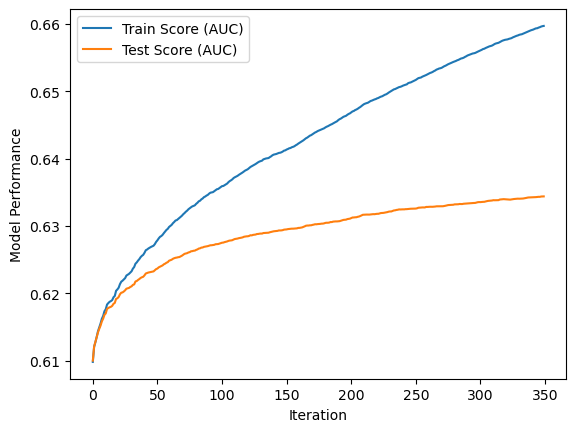

In [23]:
# 3.6
# DO NOT CHANGE THIS CELL
# plot history
history=xgb_dask_clf['history']

plt.plot(history['train']['auc'], label='Train Score (AUC)')
plt.plot(history['valid']['auc'], label='Test Score (AUC)')

plt.xlabel('Iteration')
plt.ylabel('Model Performance')
plt.legend()
plt.show()

### Step 4: Model Persistence ###
The last step for the assessment is to save the model for grading. You should improve the model until the AUC ROC is above 60%. Once completed, you should submit the model for grading. 

**Instructions**: <br>
4.1 Execute the cell below to save the model in JSON format. <br>

In [24]:
# 4.1
# DO NOT CHANGE THIS CELL
# save model
xgb_dask_clf['booster'].save_model('my_assessment/model.json')

### Grade Your Code ###
If you have trained the model and completed model evaluation successfully, save changes to the notebook and revisit the webpage where you launched this interactive environment. Click on the "**ASSESS TASK**" button as shown in the screenshot below. Doing so will give you credit for this part of the lab that counts towards earning a certificate of competency for the entire course.

<p><img src='images/credit.png' width=720></p>

<a href="https://www.nvidia.com/dli"><img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/></a>